<a href="https://colab.research.google.com/github/Rebexcode/Heart-Attack-Prediction-Model/blob/main/Heart_Attack_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

# Loading the Heart Attack Dataset

In [15]:
df = pd.read_csv('heart_statlog_cleveland_hungary_final.csv')

column_names = {
    'age': 'Age',
    'sex': 'Sex',
    'chest pain type': 'ChestPainType',
    'resting bp s': 'RestingBP',
    'cholesterol': 'Cholesterol',
    'fasting blood sugar': 'FastingBS',
    'resting ecg': 'RestingECG',
    'max heart rate': 'MaxHeartRate',
    'exercise angina': 'ExerciseAngina',
    'oldpeak': 'STDepression',
    'ST slope': 'STSlope',
    'target': 'Target'
}

# Checking if columns need renaming

In [16]:
existing_columns = set(df.columns)
columns_to_rename = {old: new for old, new in column_names.items() if old in existing_columns}
if columns_to_rename:
    df.rename(columns=columns_to_rename, inplace=True)

# Displaying Data Information

In [17]:
print("Dataset Information:")
print(f"Number of samples: {len(df)}")
print(f"Target distribution: {df['Target'].value_counts(normalize=True).to_dict()}")

Dataset Information:
Number of samples: 1190
Target distribution: {1: 0.5285714285714286, 0: 0.4714285714285714}


In [18]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHeartRate,ExerciseAngina,STDepression,STSlope,Target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


# Define features and target

In [19]:
X = df.drop('Target', axis=1)
y = df['Target']
df.Target.head(10)

,Target
0,0
1,1
2,0
3,1
4,0
5,0
6,0
7,0
8,1
9,0


# Check for missing values in the dataset

In [20]:
print("Missing Values Analysis:")
print("=" * 40)
missing_summary = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    'Column': missing_summary.index,
    'Missing_Count': missing_summary.values,
    'Missing_Percentage': missing_percentage.values
})

print(missing_df[missing_df['Missing_Count'] > 0])

if missing_df['Missing_Count'].sum() == 0:
    print("✓ No missing values found in the dataset")
else:
    print(f"Total missing values: {missing_df['Missing_Count'].sum()}")

print("\nDataset shape:", df.shape)
print("=" * 40)

Missing Values Analysis:
Empty DataFrame
Columns: [Column, Missing_Count, Missing_Percentage]
Index: []
✓ No missing values found in the dataset

Dataset shape: (1190, 12)


### Prepare Features

In [21]:
if 'Sex' in X.columns:
    X['Sex'] = X['Sex'].astype(int)

# For chest pain type (1-4)
if 'ChestPainType' in X.columns:
    X = pd.get_dummies(X, columns=['ChestPainType'], prefix='ChestPain')

# For resting ECG (0,1,2)
if 'RestingECG' in X.columns:
    X = pd.get_dummies(X, columns=['RestingECG'], prefix='ECG')

# For ST slope (0,1,2)
if 'STSlope' in X.columns:
    X = pd.get_dummies(X, columns=['STSlope'], prefix='STSlope')

# 2. Create interaction features
X['Age_MaxHR'] = X['Age'] * X['MaxHeartRate'] / 100  # Normalized interaction
X['BP_Chol'] = X['RestingBP'] * X['Cholesterol'] / 1000  # Scale for numerical stability

# Create features for cardiovascular fitness
X['MaxHR_by_Age'] = X['MaxHeartRate'] / X['Age']  # Heart rate relative to age

# Additional interaction for angina patients
if 'ExerciseAngina' in X.columns:
    X['Angina_STDepression'] = X['ExerciseAngina'] * X['STDepression']

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Apply SMOTE only to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

#Normalization and Standardization
numerical_features = X.select_dtypes(include=np.number).columns
scaler = StandardScaler()
X_train_resampled_scaled = X_train_resampled.copy()
X_train_resampled_scaled[numerical_features] = scaler.fit_transform(X_train_resampled[numerical_features])

X_test_scaled = X_test.copy()
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

# Add back any non-numeric columns
for col in X_train_resampled.columns:
    if col not in numerical_features:
        X_train_resampled_scaled[col] = X_train_resampled[col]
        X_test_scaled[col] = X_test[col]

### Encode Labels

In [62]:
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

cv_scores = cross_val_score(
    xgb_model,
    X_train_resampled_scaled,
    y_train_resampled,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

print(f"F1 scores: {cv_scores}")
print(f"Mean F1: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Train the model
xgb_model.fit(
    X_train_resampled_scaled,
    y_train_resampled,
    eval_set=[(X_test_scaled, y_test)],
    verbose=False
)


F1 scores: [0.87755102 0.91005291 0.88297872 0.92227979 0.93121693]
Mean F1: 0.9048 (+/- 0.0424)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

### Train a Mighty Random Forest

In [65]:
y_pred = xgb_model.predict(X_test_scaled)
y_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Print comprehensive metrics
print("\nFinal XGBoost Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



Final XGBoost Model Performance:
Accuracy: 0.9060
Precision: 0.9276
Recall: 0.8924
F1-Score: 0.9097
AUC-ROC: 0.9605
Confusion Matrix:
[[129  11]
 [ 17 141]]


In [51]:
# Feature importance analysis
importance_df = pd.DataFrame({
    'Feature': X_train_resampled_scaled.columns,
    'Importance': xgb_model.feature_importances_
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("\nTop 15 Most Important Features:")
print(importance_df.head(15))

# Let's also try a Random Forest with optimal parameters
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=30,
    min_samples_split=2,
    random_state=42
)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(
    rf_model,
    X_train_resampled_scaled,
    y_train_resampled,
    cv=5,
    scoring='f1'
)

print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean F1 score: {cv_scores.mean():.4f}")
print(f"Standard deviation: {cv_scores.std():.4f}")

rf_model.fit(X_train_resampled_scaled, y_train_resampled)





Top 15 Most Important Features:
                Feature  Importance
16            STSlope_1    0.258414
6        ExerciseAngina    0.126084
11          ChestPain_4    0.112827
1                   Sex    0.055001
17            STSlope_2    0.053099
22  Angina_STDepression    0.034879
4             FastingBS    0.034273
8           ChestPain_1    0.026468
3           Cholesterol    0.025480
10          ChestPain_3    0.024789
7          STDepression    0.024624
14                ECG_2    0.024260
9           ChestPain_2    0.023683
5          MaxHeartRate    0.023150
19            Age_MaxHR    0.021524
Cross-validation F1 scores: [0.89340102 0.92708333 0.91578947 0.93264249 0.94179894]
Mean F1 score: 0.9221
Standard deviation: 0.0167


RandomForestClassifier(max_depth=30, n_estimators=500, random_state=42)

In [52]:
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

print("\nOptimized Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"Sensitivity (Recall): {recall_score(y_test, y_pred_rf):.4f}")
print(f"Specificity: {recall_score(y_test, y_pred_rf, pos_label=0):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nTop 15 Most Important Features:")
print(importance_df.head(15))



Optimized Random Forest Performance:
Accuracy: 0.9161
Precision: 0.9346
Recall: 0.9051
Sensitivity (Recall): 0.9051
Specificity: 0.9286
F1-Score: 0.9196
AUC-ROC: 0.9746
Confusion Matrix:
[[130  10]
 [ 15 143]]

Top 15 Most Important Features:
                Feature  Importance
16            STSlope_1    0.258414
6        ExerciseAngina    0.126084
11          ChestPain_4    0.112827
1                   Sex    0.055001
17            STSlope_2    0.053099
22  Angina_STDepression    0.034879
4             FastingBS    0.034273
8           ChestPain_1    0.026468
3           Cholesterol    0.025480
10          ChestPain_3    0.024789
7          STDepression    0.024624
14                ECG_2    0.024260
9           ChestPain_2    0.023683
5          MaxHeartRate    0.023150
19            Age_MaxHR    0.021524


In [66]:
from sklearn.svm import SVC


svm_model = SVC(probability=True, random_state=42)

cv_scores = cross_val_score(
    svm_model,
    X_train_resampled_scaled,
    y_train_resampled,
    cv=5,
    scoring='f1'
)

print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean F1 score: {cv_scores.mean():.4f}")
print(f"Standard deviation: {cv_scores.std():.4f}")

# Fit the model to the scaled training data
svm_model.fit(X_train_resampled_scaled, y_train_resampled)

# Evaluate the SVM model
y_pred_svm = svm_model.predict(X_test_scaled)
y_pred_proba_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

print("\nSVM Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_svm):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_svm):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_svm):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_svm):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

Cross-validation F1 scores: [0.83937824 0.87878788 0.85561497 0.86458333 0.88297872]
Mean F1 score: 0.8643
Standard deviation: 0.0158

SVM Model Performance:
Accuracy: 0.8658
Precision: 0.8831
Recall: 0.8608
F1-Score: 0.8718
AUC-ROC: 0.9405
Confusion Matrix:
[[122  18]
 [ 22 136]]


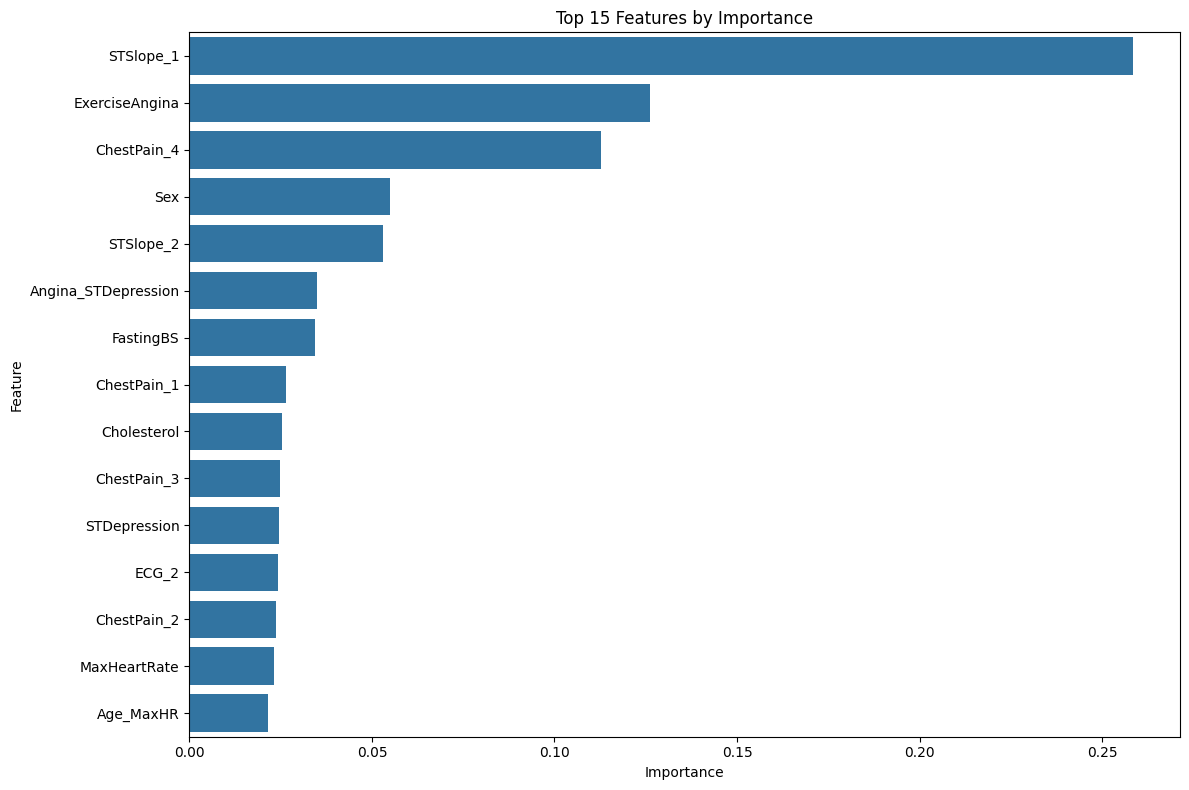

In [ ]:
# Create visualization for feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title('Top 15 Features by Importance')
plt.tight_layout()
plt.show()
plt.savefig('feature_importance.png')
plt.close()

In [ ]:
def predict_heart_disease(patient_data, model, feature_list):
    """
    Function to predict heart disease risk for new patients

    Args:
        patient_data: DataFrame containing patient information
        model: Trained model
        feature_list: List of features used by the model

    Returns:
        Predicted risk (1 = disease, 0 = no disease)
        Probability of disease
    """
    # Apply the same preprocessing
    patient_data = patient_data.copy()

    if 'Sex' in patient_data.columns:
      patient_data['Sex'] = patient_data['Sex'].astype(int)

    # For chest pain type (1-4)
    if 'ChestPainType' in patient_data.columns:
      patient_data = pd.get_dummies(patient_data, columns=['ChestPainType'], prefix='ChestPain')

    # For resting ECG (0,1,2)
    if 'RestingECG' in patient_data.columns:
      patient_data = pd.get_dummies(patient_data, columns=['RestingECG'], prefix='ECG')

    # For ST slope (0,1,2)
    if 'STSlope' in patient_data.columns:
        patient_data = pd.get_dummies(patient_data, columns=['STSlope'], prefix='STSlope')

    # 2. Create interaction features
    patient_data['Age_MaxHR'] = patient_data['Age'] * patient_data['MaxHeartRate'] / 100  # Normalized interaction
    patient_data['BP_Chol'] = patient_data['RestingBP'] * patient_data['Cholesterol'] / 1000  # Scale for numerical stability

    # Create features for cardiovascular fitness
    patient_data['MaxHR_by_Age'] = patient_data['MaxHeartRate'] / patient_data['Age']  # Heart rate relative to age

    # Additional interaction for angina patients
    if 'ExerciseAngina' in patient_data.columns:
        patient_data['Angina_STDepression'] = patient_data['ExerciseAngina'] * patient_data['STDepression']


    # Reindex the patient data to match the training data columns
    patient_data = patient_data.reindex(columns=feature_list, fill_value=0)

    # Apply the same scaling
    numerical_features = patient_data.select_dtypes(include=np.number).columns
    patient_data[numerical_features] = scaler.transform(patient_data[numerical_features])

    # Make predictions
    risk_prob = model.predict_proba(patient_data)[:, 1]
    risk = model.predict(patient_data)

    return risk, risk_prob

# Example of using the prediction function with one sample from your dataset
sample_patient = df.iloc[0:1].copy()  # First patient in the dataset
sample_patient = sample_patient.drop('Target', axis=1)  # Remove the target

# Get prediction
try:
    prediction, probability = predict_heart_disease(
        sample_patient,
        xgb_model,
        X_train_resampled_scaled.columns
    )

    print("\nSample Prediction:")
    print(f"Predicted Risk: {'Heart Disease' if prediction[0] == 1 else 'No Heart Disease'}")
    print(f"Risk Probability: {probability[0]:.4f}")
except Exception as e:
    print(f"\nError making prediction: {e}")
    print("This might be due to column naming differences between the original data and the prediction function.")


Error making prediction: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- ChestPain_1
- ChestPain_3
- ChestPain_4
- ECG_1
- ECG_2
- ...

This might be due to column naming differences between the original data and the prediction function.
